In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,recall_score
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,train_test_split
import streamlit as st
import pickle

Dalam kasus prediksi churn pelanggan, yang tujuannya adalah mengidentifikasi pelanggan yang berisiko churn untuk menerapkan strategi retensi, penarikan kembali menjadi lebih penting daripada akurasi. Hal ini karena kehilangan pelanggan yang kemungkinan besar akan churn dapat menyebabkan hilangnya pendapatan atau dampak negatif pada bisnis. Oleh karena itu, memprioritaskan penarikan kembali akan memastikan bahwa model tersebut secara efektif mengidentifikasi para churn, sehingga memungkinkan tindakan proaktif untuk mempertahankan mereka.

In [2]:
df = pd.read_csv("data_B.csv")
df.head()

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,0,37969,15780804,Ugorji,850.0,France,Male,42.0,5,0.00,2,1,1,105560.01,0
1,1,121427,15593974,Dickson,597.0,Germany,Male,46.0,9,112291.06,2,1,1,47410.06,0
2,2,151801,15655274,Teng,637.0,Germany,Male,35.0,3,145974.79,2,1,0,180934.67,0
3,3,149981,15645404,McWilliams,695.0,France,Male,39.0,8,0.00,1,1,0,162669.73,0
4,4,115198,15625881,Yobachi,695.0,France,Female,29.0,0,109109.89,1,1,0,120770.80,0


remove id dan customer id karena itu hanya index untuk mencari data dan tidak digunakan dalam model

In [3]:
df = df.drop(['Unnamed: 0', 'id', 'CustomerId','Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,850.0,France,Male,42.0,5,0.00,2,1,1,105560.01,0
1,597.0,Germany,Male,46.0,9,112291.06,2,1,1,47410.06,0
2,637.0,Germany,Male,35.0,3,145974.79,2,1,0,180934.67,0
3,695.0,France,Male,39.0,8,0.00,1,1,0,162669.73,0
4,695.0,France,Female,29.0,0,109109.89,1,1,0,120770.80,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      41251 non-null  float64
 1   Geography        41259 non-null  object 
 2   Gender           41259 non-null  object 
 3   Age              41259 non-null  float64
 4   Tenure           41259 non-null  int64  
 5   Balance          41259 non-null  float64
 6   NumOfProducts    41259 non-null  int64  
 7   HasCrCard        41259 non-null  int64  
 8   IsActiveMember   41259 non-null  int64  
 9   EstimatedSalary  41259 non-null  float64
 10  churn            41259 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 3.5+ MB


In [5]:
df = df.drop_duplicates()

memiliki null credt score 8

In [6]:
#remove outlier

def remove_outliers(dataframe, columns=None, std=3):
    """
    This function removes outliers from the given dataframe.

    Parameters:
    dataframe (pandas DataFrame): The input dataframe.
    columns (list): The list of columns to remove outliers from. If None, it will remove outliers from all numerical columns.
    std (int): The number of standard deviations to consider as an outlier.

    Returns:
    pandas DataFrame: The cleaned dataframe without outliers.
    """
    if columns is None:
        columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    for col in columns:
        q1 = dataframe[col].quantile(0.25)
        q3 = dataframe[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        dataframe = dataframe[(dataframe[col] > lower_bound) & (dataframe[col] < upper_bound)]

    return dataframe


In [7]:
#Fill null values dengan mean

df['CreditScore'] = df['CreditScore'].fillna(df['CreditScore'].median())
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 0 to 41258
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      41253 non-null  float64
 1   Geography        41253 non-null  object 
 2   Gender           41253 non-null  object 
 3   Age              41253 non-null  float64
 4   Tenure           41253 non-null  int64  
 5   Balance          41253 non-null  float64
 6   NumOfProducts    41253 non-null  int64  
 7   HasCrCard        41253 non-null  int64  
 8   IsActiveMember   41253 non-null  int64  
 9   EstimatedSalary  41253 non-null  float64
 10  churn            41253 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 3.8+ MB


null value sekarang sudah hilang

## Split Data

In [8]:
x = df.drop('churn',axis=1)
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


feature and scaling

In [9]:
df["Geography"].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,850.0,France,Male,42.0,5,0.00,2,1,1,105560.01,0
1,597.0,Germany,Male,46.0,9,112291.06,2,1,1,47410.06,0
2,637.0,Germany,Male,35.0,3,145974.79,2,1,0,180934.67,0
3,695.0,France,Male,39.0,8,0.00,1,1,0,162669.73,0
4,695.0,France,Female,29.0,0,109109.89,1,1,0,120770.80,0


In [11]:
X_train['Gender'] = X_train['Gender'].map({'Male': 0, 'Female': 1})
X_train['Geography'] = X_train['Geography'].map({'France' : 0, 'Germany': 1, 'Spain': 2})

In [37]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [12]:
#Menggunakan Zscore mengecilkan akurasi data sehingga tidak dipakai
# X_train["CreditScore"] = np.abs(stats.zscore(X_train["CreditScore"]))
# X_train["Balance"] = np.abs(stats.zscore(X_train["Balance"]))
# X_train["EstimatedSalary"] = np.abs(stats.zscore(X_train["EstimatedSalary"]))
# X_train["Age"] = np.abs(stats.zscore(X_train["Age"]))

In [13]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
40020,613.0,1,0,45.0,7,104796.54,2,1,0,80178.54
33774,576.0,2,0,63.0,9,0.00,1,1,0,78955.80
26629,488.0,0,0,63.0,6,0.00,2,1,0,93302.29
38743,383.0,1,1,48.0,3,123372.30,1,0,0,137702.01
4380,577.0,2,0,45.0,3,0.00,1,1,0,181429.87


In [14]:
#scaling 
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_Scaler = X_train
scaler = StandardScaler()
X_train_Scaler[numerical_columns] = scaler.fit_transform(X_train_Scaler[numerical_columns])

def scale_numerical_data(data, scaler):
    data[numerical_columns] = scaler.transform(data[numerical_columns])
    return data

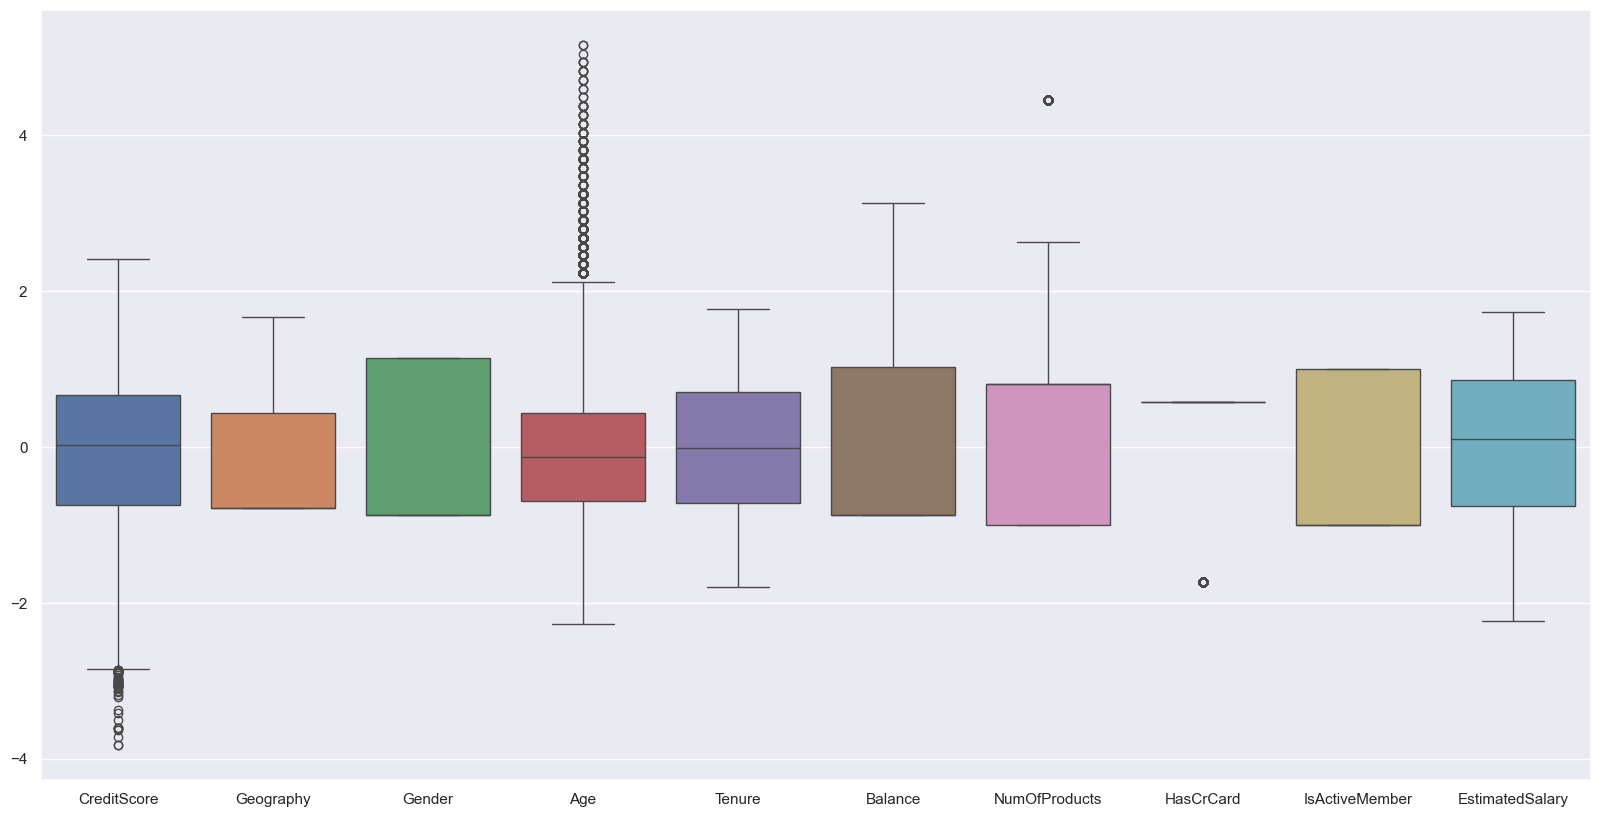

In [15]:
#mendetect outlier
#Graphical representasi dari outliers menggunakan box plot 
import seaborn as sns
column = [X_train.columns]
sns.set(rc={'figure.figsize':(20, 10)})
for i in column:
    sns.boxplot(X_train[i],)

In [16]:
df = remove_outliers(df, columns=['CreditScore', 'Age', "NumOfProducts","HasCrCard"])

Masih terdapat outliermaka akan coba  robust scaling

In [17]:
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)

Persiapan test data

In [18]:
X_test['Gender'] = X_test['Gender'].map({'Male': 0, 'Female': 1})
X_test['Geography'] = X_test['Geography'].map({'France' : 0, 'Germany': 1, 'Spain': 2})

In [19]:
X_test_Scaler = scale_numerical_data(X_test, scaler)
X_test_Robust = robust_scaler.transform(X_test)

Random forest Algorithm 

In [20]:
# Assume X_train and y_train are your training data and labels, respectively
clf = RandomForestClassifier(n_estimators=450, max_depth=15, random_state=65)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=450, random_state=65)

In [21]:
#Train accuracy in train
y_trains = clf.predict(X_train)
print("During Model training Accuracy")
print(classification_report(y_train, y_trains))

During Model training Accuracy
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26038
           1       0.97      0.81      0.88      6964

    accuracy                           0.95     33002
   macro avg       0.96      0.90      0.93     33002
weighted avg       0.96      0.95      0.95     33002



In [22]:
#Train accuracy not using any scaler
y_pred = clf.predict(X_test)
print("Non Scaler Accuracy")
print(classification_report(y_test, y_pred))

Non Scaler Accuracy
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6474
           1       0.75      0.54      0.63      1777

    accuracy                           0.86      8251
   macro avg       0.82      0.75      0.77      8251
weighted avg       0.86      0.86      0.85      8251



In [23]:
#Train accuracy using standard scaler
y_pred_standard = clf.predict(X_test_Scaler)
print("STandard Scaler Accuracy")
print(classification_report(y_test, y_pred_standard))

STandard Scaler Accuracy
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6474
           1       0.75      0.54      0.63      1777

    accuracy                           0.86      8251
   macro avg       0.82      0.75      0.77      8251
weighted avg       0.86      0.86      0.85      8251



In [24]:
#Train accuracy using robust scaler
y_pred_robust = clf.predict(X_test_Robust)
print("Non Scaler Accuracy")
print(classification_report(y_test, y_pred_robust))

c:\Users\phoebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Non Scaler Accuracy
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6474
           1       0.65      0.51      0.57      1777

    accuracy                           0.84      8251
   macro avg       0.76      0.72      0.74      8251
weighted avg       0.83      0.84      0.83      8251



In [25]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [10, 50, 100, 150, 200]
}

RFClass = GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='recall', cv=5)
RFClass.fit(X_train,y_train)
print("Tuned Hyperparameters:", RFClass.best_params_)
print("Accuracy:", RFClass.best_score_)

KeyboardInterrupt: 

In [ ]:
model_GridSearch = RandomForestClassifier(**RFClass.best_params_)  # Set the best parameters for the model
model_GridSearch.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [ ]:
y_pred_GridSearch = model_GridSearch.predict(X_test)
recall_random = recall_score(y_pred_GridSearch,y_test)

XG Boost

In [ ]:
bst = xgb.XGBClassifier(n_estimators=120, max_depth=15, learning_rate=0.01, objective='binary:logistic')

In [ ]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds = bst.predict(X_test)
preds

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7239
           1       0.45      0.79      0.57      1012

    accuracy                           0.86      8251
   macro avg       0.71      0.83      0.74      8251
weighted avg       0.90      0.86      0.87      8251



In [ ]:
bst.fit(X_train_Scaler, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds_scaled = bst.predict(X_test)
preds_scaled

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(preds_scaled,y_test))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7239
           1       0.45      0.79      0.57      1012

    accuracy                           0.86      8251
   macro avg       0.71      0.83      0.74      8251
weighted avg       0.90      0.86      0.87      8251



In [ ]:
bst.fit(X_train_robust, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds_robust = bst.predict(X_test)
preds_robust

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(preds_robust,y_test))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7566
           1       0.31      0.80      0.44       685

    accuracy                           0.83      8251
   macro avg       0.64      0.82      0.67      8251
weighted avg       0.92      0.83      0.86      8251



Best on recall is 0.84 and 0.81 using robust scaler

In [ ]:
parameters = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200, 250]
}

xgb_model = GridSearchCV(xgb.XGBClassifier(), param_grid=parameters, scoring='recall', cv=5)
xgb_model.fit(X_train, y_train)
print("Tuned Hyperparameters:", xgb_model.best_params_)
print("Accuracy:", xgb_model.best_score_)


Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Accuracy: 0.5610278403511811


In [ ]:
model_xgb = xgb.XGBClassifier(**xgb_model.best_params_)  # Set the best parameters for the model
y_pred_gridsearch = xgb_model.predict(X_test)
recall_xgb = recall_score(y_pred_GridSearch,y_test)

In [ ]:
if(recall_xgb>=recall_random):
    model_used = model_xgb
else:
    model_used = model_GridSearch
model_used.fit(X_train_robust,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [4]:
import pickle

with open('model.pickle', 'wb') as dump_var:
    pickle.dump(model_used, dump_var)

NameError: name 'model_used' is not defined

In [2]:
!streamlit run pickle_app.py 

# Load the Pickle file in memory


pickle_in = open('model.pickle', 'rb')
pickle_model = pickle.load(pickle_in)

^C


NameError: name 'pickle' is not defined

In [ ]:
from pyngrok import ngrok

# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')

# Print URL to open it in new browser window
public_url